## **Analysis of Temperature and Wind Variability Using ERA5 Data**

### **Overview**
This Jupyter Notebook analyzes temperature and wind data (u-wind and v-wind components) over a 4-day period in the **Fort McMurray** region using ERA5 reanalysis datasets. The notebook combines and processes NetCDF files representing temperature and wind components to identify grid cells with the **widest** and **narrowest temperature ranges**, and compares their wind intensity patterns.

---

### **Objectives**
1. **Combine Multi-Day ERA5 Datasets**:  
   - Merge separate NetCDF files for April 30th and May 1–3 into a single, continuous dataset.  
2. **Temperature Range Analysis**:  
   - Identify grid cells with the **widest** and **narrowest** temperature variability.  
   - Visualize temperature changes for these grid cells over the 4-day period.  
3. **Wind Component Analysis**:  
   - Extract and plot **u-wind** (East-West) and **v-wind** (North-South) components for the identified grid cells.  
   - Ensure consistent comparison by applying shared y-axis limits across wind intensity plots.  

---

### **Data Used**
- **Input**:  
   - `ERA5-land-fort-mac-April30-Temp-Wind.nc`  
   - `ERA5-land-fort-mac-May1-2-3-Temp-Wind.nc`  
   - Both files contain temperature (`t2m`) and wind components (`u10` and `v10`).  
- **Region of Interest**:  
   - Latitude: **56.0°N to 57.5°N**  
   - Longitude: **-112.5°W to -110.0°W**  
- **Output**:  
   - Combined NetCDF file: `combined_era5_fort_mcmurray_temp_wind.nc`  

---

### **Key Results**
1. **Temperature Range Comparison**:
   - Visualize temperature trends for grid cells with the **widest** and **narrowest** ranges.  
   - Highlight monthly normal temperature for comparison.  

2. **Wind Intensity Analysis**:
   - Plot the u-wind and v-wind components for the identified grid cells.  
   - Use shared y-axis limits for consistent comparison between the widest and narrowest grid cells.  

3. **Clean and Filter Data**:
   - Ensure all selected grid cells span the full time range to maintain consistency.

---

### **Dependencies**
- **Python Libraries**:  
   - `xarray`, `pandas`, `matplotlib`, `numpy`  

---

### **Visualizations**
1. **Temperature Trends**:
   - Line plots of temperature for both the widest and narrowest temperature ranges.  
2. **Wind Intensity**:
   - U-wind and V-wind component plots with shared y-axis limits for comparison.

---


Combined dataset saved to: ../data/combined_era5_fort_mcmurray_temp_wind.nc


/var/folders/ff/3wf7s3850_71q8lqw5k4t7xh0000gn/T/ipykernel_24091/3823114883.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df_clean["valid_time"].min(), end=df_clean["valid_time"].max(), freq="H")


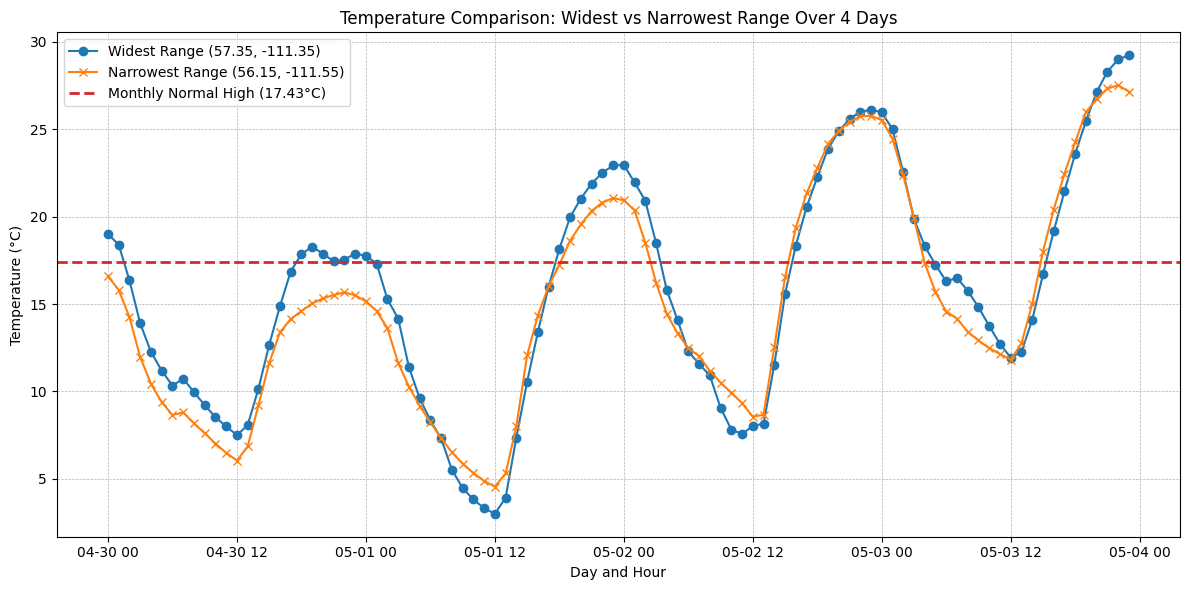

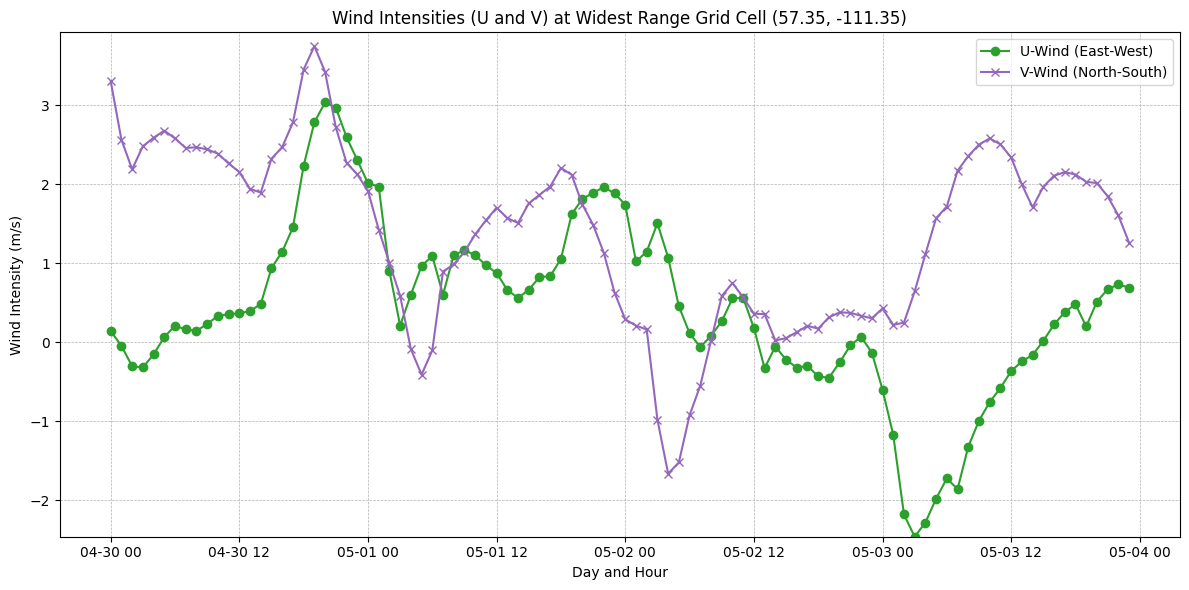

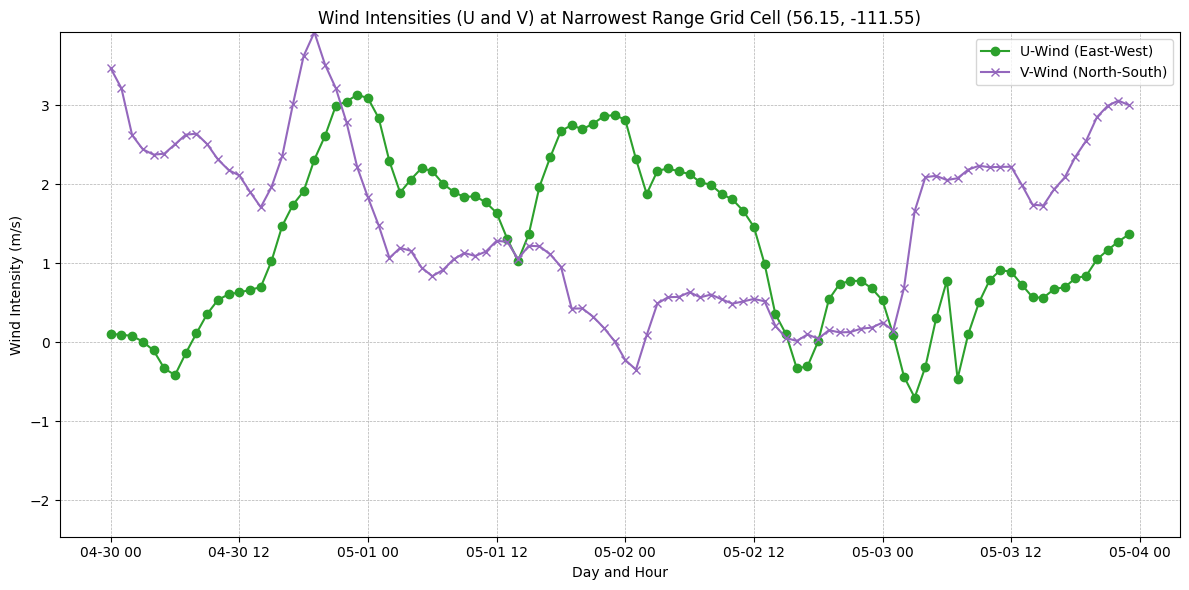

In [21]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define data directory and files
data_dir = "../data"  # Adjust path to your data folder
file1 = os.path.join(data_dir, "ERA5-land-fort-mac-April30-Temp-Wind.nc")
file2 = os.path.join(data_dir, "ERA5-land-fort-mac-May1-2-3-Temp-Wind.nc")

# Step 1: Load the datasets
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Combine datasets along the 'valid_time' dimension
combined_ds = xr.concat([ds1, ds2], dim="valid_time")
combined_ds = combined_ds.sortby("valid_time")  # Ensure continuity

# Save the combined dataset
output_file = os.path.join(data_dir, "combined_era5_fort_mcmurray_temp_wind.nc")
combined_ds.to_netcdf(output_file)
print(f"Combined dataset saved to: {output_file}")

# Step 2: Flatten the dataset to a DataFrame
df = combined_ds["t2m"].to_dataframe().reset_index()
df.rename(columns={"t2m": "temperature"}, inplace=True)

# Clean and filter the data
df_clean = df.dropna(subset=["temperature"])
df_clean = df_clean[
    (df_clean["latitude"] >= 56.0) & (df_clean["latitude"] <= 57.5) &
    (df_clean["longitude"] >= -112.5) & (df_clean["longitude"] <= -110.0)
]

# Step 3: Ensure all grid cells span the full time range
full_time_range = pd.date_range(start=df_clean["valid_time"].min(), end=df_clean["valid_time"].max(), freq="H")
grid_cell_counts = df_clean.groupby(["latitude", "longitude"])["valid_time"].nunique()
valid_cells = grid_cell_counts[grid_cell_counts == len(full_time_range)].index  # Cells covering full range

df_filtered = df_clean[df_clean.set_index(["latitude", "longitude"]).index.isin(valid_cells)]

# Step 4: Calculate temperature ranges
temperature_range = (
    df_filtered.groupby(["latitude", "longitude"])["temperature"]
    .agg(lambda x: x.max() - x.min())
    .reset_index()
    .rename(columns={"temperature": "temp_range"})
)

# Find the cells with the widest and narrowest temperature ranges
max_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmax()]
min_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmin()]

latitude_max_range, longitude_max_range = max_range_cell["latitude"], max_range_cell["longitude"]
latitude_min_range, longitude_min_range = min_range_cell["latitude"], min_range_cell["longitude"]

# Step 5: Extract temperature data for these cells
def extract_temperature_data(lat, lon):
    data = df_filtered[
        (df_filtered["latitude"] == lat) & (df_filtered["longitude"] == lon)
    ].copy()
    data["valid_time"] = pd.to_datetime(data["valid_time"])
    data["temperature_c"] = data["temperature"] - 273.15
    return data.sort_values(by="valid_time")

cell_temperature_max = extract_temperature_data(latitude_max_range, longitude_max_range)
cell_temperature_min = extract_temperature_data(latitude_min_range, longitude_min_range)

# Plot temperature ranges
plt.figure(figsize=(12, 6))
plt.plot(
    cell_temperature_max["valid_time"], cell_temperature_max["temperature_c"],
    linestyle="-", marker="o", color="tab:blue", label=f"Widest Range ({latitude_max_range:.2f}, {longitude_max_range:.2f})"
)
plt.plot(
    cell_temperature_min["valid_time"], cell_temperature_min["temperature_c"],
    linestyle="-", marker="x", color="tab:orange", label=f"Narrowest Range ({latitude_min_range:.2f}, {longitude_min_range:.2f})"
)
plt.axhline(y=17.43, color="tab:red", linestyle="--", linewidth=2, label="Monthly Normal High (17.43°C)")
plt.title("Temperature Comparison: Widest vs Narrowest Range Over 4 Days")
plt.xlabel("Day and Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Step 6: Extract and plot u-wind and v-wind for both cells with shared y-axis limits
def extract_wind_data(lat, lon):
    """Extract u-wind and v-wind data for a given latitude and longitude."""
    u_wind = combined_ds["u10"].sel(latitude=lat, longitude=lon).to_dataframe().reset_index()
    v_wind = combined_ds["v10"].sel(latitude=lat, longitude=lon).to_dataframe().reset_index()
    u_wind["valid_time"] = pd.to_datetime(u_wind["valid_time"])
    v_wind["valid_time"] = pd.to_datetime(v_wind["valid_time"])
    return u_wind, v_wind

# Extract wind data for widest and narrowest range cells
u_wind_max, v_wind_max = extract_wind_data(latitude_max_range, longitude_max_range)
u_wind_min, v_wind_min = extract_wind_data(latitude_min_range, longitude_min_range)

# Determine shared y-axis limits
wind_min = min(u_wind_max["u10"].min(), v_wind_max["v10"].min(), u_wind_min["u10"].min(), v_wind_min["v10"].min())
wind_max = max(u_wind_max["u10"].max(), v_wind_max["v10"].max(), u_wind_min["u10"].max(), v_wind_min["v10"].max())

# Function to plot wind components with shared y-axis limits
def plot_wind_components_with_limits(u_wind, v_wind, label, lat, lon):
    plt.figure(figsize=(12, 6))
    plt.plot(u_wind["valid_time"], u_wind["u10"], linestyle="-", marker="o", color="tab:green", label="U-Wind (East-West)")
    plt.plot(v_wind["valid_time"], v_wind["v10"], linestyle="-", marker="x", color="tab:purple", label="V-Wind (North-South)")
    plt.ylim(wind_min, wind_max)  # Set shared y-axis limits
    plt.title(f"Wind Intensities (U and V) at {label} Range Grid Cell ({lat:.2f}, {lon:.2f})")
    plt.xlabel("Day and Hour")
    plt.ylabel("Wind Intensity (m/s)")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plot wind components with shared y-axis limits
plot_wind_components_with_limits(u_wind_max, v_wind_max, "Widest", latitude_max_range, longitude_max_range)
plot_wind_components_with_limits(u_wind_min, v_wind_min, "Narrowest", latitude_min_range, longitude_min_range)

